In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import time

tempoInicial = time.time()

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psix(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [3]:
def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 2000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = np.pi
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psix(0, xs) + 0.60 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [4]:
def multMatrizes(M, us, O = 0, L = 10, T = 10):
    N = 2000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = np.pi
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*(w+us)**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()

    return np.matmul(np.linalg.inv(matrizA), matrizB)

In [5]:
# Gradiente e função objetivo

def ExactSolution(M, T = 5, L = 5):
    N = 2000

    xs = np.linspace(-5, L, M)
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.1):
        for j in np.arange(0, 20, 0.01):
            psiExato[r][int(j*100)] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    return psiExato

def Objetivo(x, y, psi, psiExato):
    A = np.zeros((100,100))
    B = np.zeros((100,100))
    C = np.zeros((100,100))
    D = np.zeros((100,100))
    A = multMatrizes(M = 100, us = x[0])
    B = multMatrizes(M = 100, us = x[1])
    C = multMatrizes(M = 100, us = x[0])
    D = multMatrizes(M = 100, us = x[1])
    
    Y = np.matmul(A,psi[0:100, y])
    Z = np.matmul(B, Y)
    W = np.matmul(C, Z)
    X = np.matmul(D, W)
    
    return ((np.linalg.norm(np.array(psiExato[0:100, y])-np.array(psi[0:100, y])))**2+
            (np.linalg.norm(np.array(psiExato[0:100, y+1])-np.array(Y)))**2+
            (np.linalg.norm(np.array(psiExato[0:100, y+2])-np.array(Z)))**2+
            (np.linalg.norm(np.array(psiExato[0:100, y+3])-np.array(W)))**2+
            (np.linalg.norm(np.array(psiExato[0:100, y+4])-np.array(X)))**2)

In [6]:
import random

psi = np.zeros((100,2000))
psi_f = np.zeros((100,2000))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 100, O = -5, L = 5, T = 20)
psiExato = ExactSolution(M = 100)

In [7]:
xs = np.linspace(-5,5,100)

[-2.566194825897651, -1.6264266989047726, 1.4623942961518939, -3.248869886004919]
Iteração: 1
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.6740079000487496
       x: [-2.248e+00 -2.189e+00  1.462e+00 -3.249e+00]
     nit: 10
     jac: [ 4.068e-06  4.590e-06  0.000e+00  0.000e+00]
    nfev: 100
    njev: 20
---------------
[-2.2483820337931166, 4.09348436373665, -3.1649849443826152, -1.3987485194528904]
Iteração: 2
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.7035192031253583
       x: [-4.059e+00 -2.195e+00 -3.165e+00 -1.399e+00]
     nit: 13
     jac: [-1.982e-06  1.311e-06  0.000e+00  0.000e+00]
    nfev: 165
    njev: 33
---------------
[-4.059396251872561, -4.950267980216654, 2.6153083654634397, -3.532734820412072]
Iteração: 3
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.744851428325545
       x: [-4.066e+00 -4.087e+00  2.615e+00 -3.533e+00]
     nit: 10
   

Iteração: 24
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5.345293584783728
       x: [-2.211e+00 -2.195e+00 -7.098e-01  2.241e+00]
     nit: 15
     jac: [-4.649e-06 -3.219e-06  0.000e+00  0.000e+00]
    nfev: 165
    njev: 33
---------------
[-2.2109647618941835, -4.9248785165585325, -0.34334701832463654, -4.074907645457387]
Iteração: 25
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5.712025231999405
       x: [-2.320e+00 -4.359e+00 -3.433e-01 -4.075e+00]
     nit: 9
     jac: [ 5.066e-06 -1.788e-06  0.000e+00  0.000e+00]
    nfev: 95
    njev: 19
---------------
[-2.32017516854115, 0.4460441849934558, 2.196729909475846, 4.014507873500589]
Iteração: 26
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 14.60304622681343
       x: [-1.970e+00 -2.195e+00  2.197e+00  4.015e+00]
     nit: 12
     jac: [ 9.537e-06  5.364e-06  0.000e+00  0.000e+00]
    nfev: 145
    njev: 29
---

Iteração: 47
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15.223223824047118
       x: [-4.081e+00 -2.191e+00  4.308e+00 -4.694e+00]
     nit: 12
     jac: [ 1.907e-06 -3.576e-07  0.000e+00  0.000e+00]
    nfev: 165
    njev: 33
---------------
[-4.0814901607368546, -4.259441881165015, 4.072305695677226, -0.38981267552896703]
Iteração: 48
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15.790716826025147
       x: [-4.082e+00 -4.092e+00  4.072e+00 -3.898e-01]
     nit: 8
     jac: [-3.457e-06  9.298e-06  0.000e+00  0.000e+00]
    nfev: 95
    njev: 19
---------------
[-4.082159892556333, -0.06993928321390808, -2.6803269696113317, -2.5450079777776624]
Iteração: 49
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 16.369502043445028
       x: [-4.082e+00 -2.191e+00 -2.680e+00 -2.545e+00]
     nit: 9
     jac: [-3.099e-06 -2.623e-06  0.000e+00  0.000e+00]
    nfev: 115
    njev:

Iteração: 70
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 31.050815357620348
       x: [-4.093e+00 -2.191e+00  7.353e-01 -2.284e+00]
     nit: 13
     jac: [ 0.000e+00  2.384e-07  0.000e+00  0.000e+00]
    nfev: 175
    njev: 35
---------------
[-4.093070569466908, 3.8399256693642307, -3.4451014667256405, -0.7352997268327099]
Iteração: 71
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 31.86508248011745
       x: [-2.190e+00 -2.191e+00 -3.445e+00 -7.353e-01]
     nit: 11
     jac: [ 5.960e-06  5.722e-06  0.000e+00  0.000e+00]
    nfev: 160
    njev: 32
---------------
[-2.1896679996785866, -2.098692175344107, 1.0234174183977167, -2.909923162820738]
Iteração: 72
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 32.689231494989144
       x: [-2.189e+00 -2.192e+00  1.023e+00 -2.910e+00]
     nit: 3
     jac: [ 4.292e-06 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9


Iteração: 93
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 52.07699456542454
       x: [-2.182e+00 -2.221e+00 -7.179e-02 -3.702e-01]
     nit: 16
     jac: [-4.768e-06 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 230
    njev: 46
---------------
[-2.182114757182699, 1.9658394688770837, 0.30655017276202123, 2.7927692595908127]
Iteração: 94
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 53.08775111372272
       x: [-2.182e+00 -2.225e+00  3.066e-01  2.793e+00]
     nit: 15
     jac: [-8.583e-06  2.384e-06  0.000e+00  0.000e+00]
    nfev: 220
    njev: 44
---------------
[-2.1822627271936423, -0.3070963846921506, -4.527513695167629, 3.073100208619495]
Iteração: 95
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 54.10523404368713
       x: [-2.181e+00 -2.230e+00 -4.528e+00  3.073e+00]
     nit: 13
     jac: [ 2.861e-06  3.338e-06  0.000e+00  0.000e+00]
    nfev: 185
    njev: 37


Iteração: 116
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 71.5331996980864
       x: [-3.142e+00 -3.142e+00  1.828e-01  4.869e+00]
     nit: 2
     jac: [-9.537e-07 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11
---------------
[-3.1416024022860567, 3.91572867495225, -4.105742563367948, 1.5029492621364486]
Iteração: 117
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 72.50191720984573
       x: [-3.142e+00  1.217e+00 -4.106e+00  1.503e+00]
     nit: 3
     jac: [ 0.000e+00  4.768e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.141596151554046, -4.876383035488548, -4.016212489333614, -4.068166869602454]
Iteração: 118
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 78.52569843726428
       x: [-3.142e+00 -3.142e+00 -4.016e+00 -4.068e+00]
     nit: 6
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 75
    njev: 15
--------

Iteração: 139
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 84.40154722737083
       x: [-1.642e+00 -1.670e+00 -3.075e+00 -4.574e+00]
     nit: 6
     jac: [ 3.815e-06  5.722e-06  0.000e+00  0.000e+00]
    nfev: 80
    njev: 16
---------------
[-1.6418070267713427, 3.459708307866027, -3.898189840136049, -4.582162603335879]
Iteração: 140
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 84.30159126826283
       x: [-4.620e+00 -1.692e+00 -3.898e+00 -4.582e+00]
     nit: 12
     jac: [-9.537e-07  2.861e-06  0.000e+00  0.000e+00]
    nfev: 170
    njev: 34
---------------
[-4.619931685885973, 4.418862923747392, 2.4305803411155624, 2.2429986331833796]
Iteração: 141
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 84.182242611894
       x: [-1.684e+00 -1.713e+00  2.431e+00  2.243e+00]
     nit: 11
     jac: [-9.537e-07 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 160
    njev: 32
----

Iteração: 162
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 79.39546499153775
       x: [-2.002e+00 -2.035e+00  3.655e+00 -8.552e-01]
     nit: 3
     jac: [ 2.861e-06 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-2.002279074649824, 2.635980899152802, -1.0477229027968304, 2.188482585027984]
Iteração: 163
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 79.13370477141264
       x: [-4.270e+00 -2.045e+00 -1.048e+00  2.188e+00]
     nit: 8
     jac: [ 1.907e-06  4.768e-06  0.000e+00  0.000e+00]
    nfev: 115
    njev: 23
---------------
[-4.270028342584989, -2.5549579614937965, -3.1031559804851403, -4.886112607575823]
Iteração: 164
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 78.87365790969446
       x: [-4.261e+00 -2.055e+00 -3.103e+00 -4.886e+00]
     nit: 7
     jac: [ 4.768e-06 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 105
    njev: 21
---

Iteração: 185
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74.42164927203372
       x: [-2.162e+00 -2.196e+00  4.931e+00  1.256e+00]
     nit: 9
     jac: [-7.629e-06  1.907e-06  0.000e+00  0.000e+00]
    nfev: 145
    njev: 29
---------------
[-2.1621585554885825, 0.2583661428370032, 4.4105168438413695, 2.439258264193599]
Iteração: 186
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74.27929031599805
       x: [-2.165e+00 -2.201e+00  4.411e+00  2.439e+00]
     nit: 8
     jac: [ 3.815e-06 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 125
    njev: 25
---------------
[-2.1654186471986985, -1.8165135290861478, -1.9167827937911799, 0.10985645061209404]
Iteração: 187
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74.14466634582426
       x: [-2.170e+00 -2.205e+00 -1.917e+00  1.099e-01]
     nit: 9
     jac: [ 9.537e-07 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 130
    njev: 2

Iteração: 208
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 68.51757613579178
       x: [-2.704e+00 -2.169e+00 -2.608e+00  1.618e+00]
     nit: 8
     jac: [ 9.537e-06 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 140
    njev: 28
---------------
[-2.7038544521636636, 2.9929775714394484, 0.2696256288836132, -4.22129108489106]
Iteração: 209
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 73.30260740570115
       x: [-3.957e+00 -2.240e+00  2.696e-01 -4.221e+00]
     nit: 12
     jac: [ 5.722e-06 -6.676e-06  0.000e+00  0.000e+00]
    nfev: 175
    njev: 35
---------------
[-3.956673001845736, 2.02979552358351, 4.390710269489361, -4.355274814616374]
Iteração: 210
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 73.36442008802359
       x: [-4.028e+00 -2.263e+00  4.391e+00 -4.355e+00]
     nit: 18
     jac: [-8.583e-06 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 300
    njev: 60
---

Iteração: 231
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 71.25988566825448
       x: [-1.945e+00 -3.143e+00  3.199e+00  6.316e-01]
     nit: 14
     jac: [ 2.861e-06 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 230
    njev: 46
---------------
[-1.9453976303767564, 1.6099243309511717, -0.5982785749002577, -1.551369912841476]
Iteração: 232
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 71.50083179028837
       x: [-2.339e+00 -2.510e+00 -5.983e-01 -1.551e+00]
     nit: 12
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 240
    njev: 48
---------------
[-2.3388676031695543, 2.2024598483355753, 3.133170646039824, 2.2111971460606306]
Iteração: 233
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 71.67791512594377
       x: [-3.732e+00 -2.236e+00  3.133e+00  2.211e+00]
     nit: 14
     jac: [ 5.722e-06 -4.768e-06  0.000e+00  0.000e+00]
    nfev: 275
    njev: 

Iteração: 254
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 83.83419134987604
       x: [-2.325e+00 -2.406e+00  2.087e+00 -4.850e-01]
     nit: 13
     jac: [ 3.815e-06 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 245
    njev: 49
---------------
[-2.325143018523973, -2.8245442561603804, 4.608849584429603, -0.08087863493858904]
Iteração: 255
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 84.21810638523844
       x: [-2.332e+00 -2.414e+00  4.609e+00 -8.088e-02]
     nit: 6
     jac: [ 2.861e-06  2.861e-06  0.000e+00  0.000e+00]
    nfev: 155
    njev: 31
---------------
[-2.3320084806782178, 0.18192487387787537, -3.6342490295521843, 1.1048259039372175]
Iteração: 256
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 84.60691666647651
       x: [-2.336e+00 -2.425e+00 -3.634e+00  1.105e+00]
     nit: 9
     jac: [ 0.000e+00  2.861e-06  0.000e+00  0.000e+00]
    nfev: 190
    njev:

Iteração: 277
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 89.34299517055538
       x: [-1.307e+01  4.680e+00  2.155e+00  1.905e+00]
     nit: 13
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 135
    njev: 27
---------------
[-13.067139924106211, 2.5486516226439306, -1.5207153198148307, -1.1864520725133176]
Iteração: 278
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 87.3454240363633
       x: [-1.218e+01  2.109e+00 -1.521e+00 -1.186e+00]
     nit: 6
     jac: [-3.815e-06  9.537e-07  0.000e+00  0.000e+00]
    nfev: 75
    njev: 15
---------------
[-12.176350480106926, -0.26673697094537463, 3.0555845841704308, -0.9059712198124839]
Iteração: 279
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 83.36873173416545
       x: [-1.106e+01 -2.982e+00  3.056e+00 -9.060e-01]
     nit: 18
     jac: [ 1.907e-06  3.815e-06  0.000e+00  0.000e+00]
    nfev: 200
    njev

Iteração: 300
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 68.57813524578755
       x: [-4.394e+00 -1.821e+00 -1.149e+00  8.922e-01]
     nit: 10
     jac: [ 9.537e-06 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 175
    njev: 35
---------------
[-4.394255138483484, 4.66064530538967, 2.182837859768334, -1.030559636100171]
Iteração: 301
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 68.14814760252223
       x: [-4.396e+00 -1.818e+00  2.183e+00 -1.031e+00]
     nit: 11
     jac: [-5.722e-06 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 195
    njev: 39
---------------
[-4.396302319837771, -1.9649553153045494, -2.443221570039209, 4.862452093699261]
Iteração: 302
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 67.72909855635596
       x: [-4.397e+00 -1.815e+00 -2.443e+00  4.862e+00]
     nit: 6
     jac: [-2.861e-06  2.861e-06  0.000e+00  0.000e+00]
    nfev: 115
    njev: 23
---

Iteração: 323
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 61.9446240766758
       x: [-4.406e+00 -4.507e+00  2.227e-01  4.808e+00]
     nit: 13
     jac: [-3.338e-06 -8.106e-06  0.000e+00  0.000e+00]
    nfev: 180
    njev: 36
---------------
[-4.405960794557438, 0.8727354297367143, 1.4914346127755422, 4.525349818924255]
Iteração: 324
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 61.83304073203373
       x: [-4.407e+00 -1.775e+00  1.491e+00  4.525e+00]
     nit: 15
     jac: [ 6.676e-06 -9.060e-06  0.000e+00  0.000e+00]
    nfev: 225
    njev: 45
---------------
[-4.406664015872842, 1.673644225945898, -0.12336027081120893, 4.492288853287306]
Iteração: 325
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 61.73788021005806
       x: [-4.406e+00 -1.772e+00 -1.234e-01  4.492e+00]
     nit: 11
     jac: [ 4.768e-07  5.722e-06  0.000e+00  0.000e+00]
    nfev: 175
    njev: 35
-

Iteração: 346
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 63.69703050937908
       x: [-4.404e+00 -1.712e+00  2.531e+00  3.283e-01]
     nit: 12
     jac: [ 4.768e-07 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 230
    njev: 46
---------------
[-4.403718966523261, 1.8021295539076796, 4.053860075315997, 2.222979839947734]
Iteração: 347
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 63.980264013983295
       x: [-4.403e+00 -1.707e+00  4.054e+00  2.223e+00]
     nit: 17
     jac: [ 4.292e-06 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 250
    njev: 50
---------------
[-4.403414183213813, -3.650573320330932, -1.873877405255635, 4.1415040776117245]
Iteração: 348
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 64.28027811146077
       x: [-4.404e+00 -4.581e+00 -1.874e+00  4.142e+00]
     nit: 14
     jac: [ 1.907e-06  5.722e-06  0.000e+00  0.000e+00]
    nfev: 235
    njev: 47


Iteração: 369
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74.07386939704053
       x: [-4.403e+00 -4.780e+00 -4.612e+00 -2.769e+00]
     nit: 3
     jac: [-4.768e-06  4.768e-06  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12
---------------
[-4.40273337367559, 1.6571206186938436, -0.5371811037490009, -1.010549722660139]
Iteração: 370
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74.68190884665192
       x: [-4.400e+00 -1.485e+00 -5.372e-01 -1.011e+00]
     nit: 9
     jac: [-1.907e-06 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 160
    njev: 32
---------------
[-4.4000768278778555, 1.002901122760215, 2.93229783393088, -4.153075746913753]
Iteração: 371
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 75.30006943216324
       x: [-4.398e+00 -1.465e+00  2.932e+00 -4.153e+00]
     nit: 10
     jac: [ 2.861e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 190
    njev: 38
----

Iteração: 392
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 82.50223253069458
       x: [-1.161e+00 -1.365e+00 -6.106e-01 -4.808e-01]
     nit: 9
     jac: [ 5.722e-06 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 170
    njev: 34
---------------
[-1.160834868370892, 4.8571188776219145, 1.9684328604650583, -1.0862484868666265]
Iteração: 393
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 82.54395949571031
       x: [-1.171e+00 -1.356e+00  1.968e+00 -1.086e+00]
     nit: 12
     jac: [ 6.676e-06  9.537e-06  0.000e+00  0.000e+00]
    nfev: 190
    njev: 38
---------------
[-1.1709865605787666, 2.62643282467727, -3.0244468257918875, -1.3445183379043648]
Iteração: 394
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 82.59083134378389
       x: [-1.171e+00 -1.345e+00 -3.024e+00 -1.345e+00]
     nit: 12
     jac: [ 5.722e-06  2.861e-06  0.000e+00  0.000e+00]
    nfev: 200
    njev: 4

Iteração: 415
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 72.63349852473087
       x: [-8.224e-01 -8.740e-01 -4.361e+00 -4.564e+00]
     nit: 8
     jac: [-2.861e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 155
    njev: 31
---------------
[-0.8223651118279471, 3.8579498655874183, 2.776660579369362, 2.632745312615908]
Iteração: 416
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 78.04676577147623
       x: [-8.564e-01 -9.584e-01  2.777e+00  2.633e+00]
     nit: 9
     jac: [-9.537e-06 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 155
    njev: 31
---------------
[-0.8563862546309582, -0.34204708634622083, -4.629053603789598, -2.5206456808675473]
Iteração: 417
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 77.3075614191246
       x: [-9.257e-01 -1.020e+00 -4.629e+00 -2.521e+00]
     nit: 13
     jac: [ 3.815e-06  6.676e-06  0.000e+00  0.000e+00]
    nfev: 190
    njev: 38

Iteração: 438
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 58.65607647770275
       x: [-9.222e-01 -2.265e+00  3.990e+00 -2.035e+00]
     nit: 17
     jac: [ 9.537e-07 -4.768e-07  0.000e+00  0.000e+00]
    nfev: 270
    njev: 54
---------------
[-0.9221513945308843, -2.181878679685126, -3.31430313200177, 4.237973899304109]
Iteração: 439
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 57.898656561606174
       x: [-2.057e+00 -1.167e+00 -3.314e+00  4.238e+00]
     nit: 19
     jac: [ 2.861e-06  3.815e-06  0.000e+00  0.000e+00]
    nfev: 290
    njev: 58
---------------
[-2.056766522170818, 1.1758126027232985, -4.495282927222908, 2.0593958038284486]
Iteração: 440
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 57.37163331630722
       x: [-1.497e+00 -1.358e+00 -4.495e+00  2.059e+00]
     nit: 12
     jac: [-4.768e-07 -4.768e-07  0.000e+00  0.000e+00]
    nfev: 185
    njev: 37

Iteração: 461
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 46.22942951747609
       x: [-4.986e+00 -1.614e+00 -2.864e+00  3.197e+00]
     nit: 12
     jac: [-2.861e-06 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 205
    njev: 41
---------------
[-4.985529803707895, 0.42856924244578387, 3.8912527964698906, -1.9783478522914102]
Iteração: 462
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.662698638684134
       x: [-4.285e+00 -1.374e+00  3.891e+00 -1.978e+00]
     nit: 11
     jac: [ 2.861e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 170
    njev: 34
---------------
[-4.2845373516244525, 0.35419940481196655, -1.9395301496915982, 0.48053592723763927]
Iteração: 463
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.10812493857862
       x: [-5.041e+00 -2.478e+00 -1.940e+00  4.805e-01]
     nit: 14
     jac: [-1.907e-06 -4.768e-07  0.000e+00  0.000e+00]
    nfev: 220
    n

Iteração: 484
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 36.81820275923902
       x: [-1.907e+00 -1.919e+00  2.909e+00  4.815e+00]
     nit: 10
     jac: [ 7.629e-06 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 150
    njev: 30
---------------
[-1.9065792510082689, 2.037933389094322, -2.207100996238822, -0.23177282858130077]
Iteração: 485
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 36.62886962771616
       x: [-2.065e+00 -1.570e+00 -2.207e+00 -2.318e-01]
     nit: 9
     jac: [ 7.153e-06  9.060e-06  0.000e+00  0.000e+00]
    nfev: 140
    njev: 28
---------------
[-2.0652948324455647, 0.7537727949894677, -3.1345691744029693, 2.884071682469104]
Iteração: 486
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 39.14121944447395
       x: [-1.619e+00 -1.934e+00 -3.135e+00  2.884e+00]
     nit: 15
     jac: [-5.722e-06 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 235
    njev: 

Iteração: 507
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 39.80687950306297
       x: [-2.110e+00 -2.174e+00  3.576e+00 -2.768e+00]
     nit: 9
     jac: [-9.060e-06 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 140
    njev: 28
---------------
[-2.1095540474044454, -0.244379049347911, -0.779832815003596, -3.052458143317235]
Iteração: 508
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 40.18996552865674
       x: [-2.117e+00 -2.184e+00 -7.798e-01 -3.052e+00]
     nit: 10
     jac: [ 3.338e-06 -4.768e-07  0.000e+00  0.000e+00]
    nfev: 150
    njev: 30
---------------
[-2.1165576313463643, 3.0281313899004516, 2.105395894918388, 0.8273916158591295]
Iteração: 509
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 40.59101529105172
       x: [-2.125e+00 -2.192e+00  2.105e+00  8.274e-01]
     nit: 12
     jac: [-4.768e-07  2.861e-06  0.000e+00  0.000e+00]
    nfev: 215
    njev: 43

Iteração: 530
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 52.013599814425255
       x: [-2.258e+00 -2.327e+00 -4.794e+00  1.537e-01]
     nit: 9
     jac: [ 4.292e-06  1.431e-06  0.000e+00  0.000e+00]
    nfev: 145
    njev: 29
---------------
[-2.2579141140106374, -0.9868143939616791, 0.05273039613444741, -1.4878810891967706]
Iteração: 531
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 52.63749628560406
       x: [-4.020e+00 -2.331e+00  5.273e-02 -1.488e+00]
     nit: 10
     jac: [ 2.384e-06 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 165
    njev: 33
---------------
[-4.0203111103342, 3.0935831297720178, 1.115906220840925, -4.896530636150933]
Iteração: 532
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 53.26244327141689
       x: [-2.267e+00 -2.334e+00  1.116e+00 -4.897e+00]
     nit: 14
     jac: [ 8.583e-06  6.676e-06  0.000e+00  0.000e+00]
    nfev: 200
    njev: 4

Iteração: 553
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 65.19347088941365
       x: [-2.320e+00 -2.341e+00 -1.732e+00 -4.739e+00]
     nit: 14
     jac: [-7.629e-06 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 245
    njev: 49
---------------
[-2.3195203107921745, -0.8718088418428147, -0.8986264261921928, -3.9703494990203048]
Iteração: 554
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 65.64211564815257
       x: [-2.320e+00 -2.339e+00 -8.986e-01 -3.970e+00]
     nit: 5
     jac: [-2.861e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 80
    njev: 16
---------------
[-2.3199743068610466, 3.439679372556723, 4.230567573176446, 3.871410264080108]
Iteração: 555
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 66.07497811178392
       x: [-3.963e+00 -2.337e+00  4.231e+00  3.871e+00]
     nit: 9
     jac: [-1.907e-06  5.722e-06  0.000e+00  0.000e+00]
    nfev: 140
    njev: 28


Iteração: 576
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 70.87538111215058
       x: [-3.987e+00 -2.269e+00  3.021e+00  4.965e-01]
     nit: 9
     jac: [-3.815e-06 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 140
    njev: 28
---------------
[-3.987107023342307, -4.254943474924292, -3.529998442796196, 0.0098320693592866]
Iteração: 577
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 70.88456966816139
       x: [-3.989e+00 -4.019e+00 -3.530e+00  9.832e-03]
     nit: 7
     jac: [ 8.583e-06 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 95
    njev: 19
---------------
[-3.988664068898391, -3.4590441183615606, -1.2367552386502778, 3.555689667481637]
Iteração: 578
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 70.87389735870906
       x: [-3.992e+00 -4.022e+00 -1.237e+00  3.556e+00]
     nit: 9
     jac: [-1.907e-06 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 125
    njev: 25
--

Iteração: 599
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 66.66058463989
       x: [-2.233e+00 -2.181e+00  2.916e+00 -1.911e-01]
     nit: 10
     jac: [ 9.537e-07  9.537e-07  0.000e+00  0.000e+00]
    nfev: 145
    njev: 29
---------------
[-2.233098250192159, -4.036343694073279, -3.9190689714736937, -4.624570355761818]
Iteração: 600
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 66.3106248401704
       x: [-2.230e+00 -4.107e+00 -3.919e+00 -4.625e+00]
     nit: 5
     jac: [ 9.537e-07 -6.676e-06  0.000e+00  0.000e+00]
    nfev: 75
    njev: 15
---------------
[-2.2303545759355057, -2.7776528293191607, 2.4484165661386195, 3.5022688605491084]
Iteração: 601
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 65.95166117327176
       x: [-2.227e+00 -2.173e+00  2.448e+00  3.502e+00]
     nit: 10
     jac: [-5.722e-06 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 150
    njev: 30
--

Iteração: 622
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 57.55864324921141
       x: [-2.159e+00 -2.098e+00 -2.147e+00  5.357e-01]
     nit: 11
     jac: [ 4.768e-07  4.768e-07  0.000e+00  0.000e+00]
    nfev: 145
    njev: 29
---------------
[-2.158989359080758, -1.1846579599226748, 1.9496827233488387, 2.1630667476365932]
Iteração: 623
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 57.175587197094
       x: [-2.155e+00 -2.094e+00  1.950e+00  2.163e+00]
     nit: 8
     jac: [-3.815e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 125
    njev: 25
---------------
[-2.15532117738306, 1.732363023706914, -2.6962006306086717, 1.4078003952431395]
Iteração: 624
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 56.7989053726917
       x: [-2.152e+00 -2.090e+00 -2.696e+00  1.408e+00]
     nit: 13
     jac: [-2.861e-06  4.768e-07  0.000e+00  0.000e+00]
    nfev: 180
    njev: 36
---

Iteração: 645
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 51.18048447126049
       x: [-2.055e+00 -1.979e+00  2.161e+00  6.222e-01]
     nit: 7
     jac: [ 6.676e-06  4.292e-06  0.000e+00  0.000e+00]
    nfev: 95
    njev: 19
---------------
[-2.054632224020857, 1.3977300653981768, -0.371008941244404, 2.6196020827621345]
Iteração: 646
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 51.05002459366327
       x: [-2.049e+00 -1.972e+00 -3.710e-01  2.620e+00]
     nit: 10
     jac: [-5.722e-06 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 120
    njev: 24
---------------
[-2.0487092561856644, 4.655460103283275, -1.8847924629957125, -4.517845666087872]
Iteração: 647
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 50.93344222438747
       x: [-4.241e+00 -1.965e+00 -1.885e+00 -4.518e+00]
     nit: 10
     jac: [-9.537e-07 -9.537e-06  0.000e+00  0.000e+00]
    nfev: 150
    njev: 30


Iteração: 668
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 51.45042921138257
       x: [-4.436e+00 -1.712e+00 -8.601e-01  4.752e+00]
     nit: 9
     jac: [ 4.768e-06 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 125
    njev: 25
---------------
[-4.435821963576838, 4.261120969312778, -3.3570586154212867, 3.3295383584903053]
Iteração: 669
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 51.58652001085066
       x: [-1.834e+00 -1.694e+00 -3.357e+00  3.330e+00]
     nit: 13
     jac: [-4.768e-07 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 190
    njev: 38
---------------
[-1.8335115705962377, -1.852101678928845, 3.5371743005929925, 4.321307992805616]
Iteração: 670
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 51.72805286357089
       x: [-1.819e+00 -1.676e+00  3.537e+00  4.321e+00]
     nit: 8
     jac: [ 4.768e-07 -7.153e-06  0.000e+00  0.000e+00]
    nfev: 105
    njev: 21
-

Iteração: 691
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 53.744989490410354
       x: [-1.447e+00 -1.265e+00 -2.677e+00  3.428e+00]
     nit: 11
     jac: [ 0.000e+00  4.768e-06  0.000e+00  0.000e+00]
    nfev: 160
    njev: 32
---------------
[-1.4473695441581718, -3.658307115664481, 3.267539671336566, 1.6480946343519598]
Iteração: 692
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 53.6726518194785
       x: [-1.437e+00 -5.022e+00  3.268e+00  1.648e+00]
     nit: 10
     jac: [-9.060e-06 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 160
    njev: 32
---------------
[-1.4367956850102126, 3.591545678390993, 2.317594548807519, -1.7410177535976135]
Iteração: 693
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 53.57599762943385
       x: [-4.855e+00 -1.262e+00  2.318e+00 -1.741e+00]
     nit: 12
     jac: [-1.907e-06  6.676e-06  0.000e+00  0.000e+00]
    nfev: 190
    njev: 38

Iteração: 714
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 47.578534295855064
       x: [-4.565e+00 -4.605e+00 -5.329e-01 -8.468e-01]
     nit: 9
     jac: [ 7.629e-06  9.537e-07  0.000e+00  0.000e+00]
    nfev: 115
    njev: 23
---------------
[-4.565422406868993, -4.3351881669867876, 2.946384956869438, -4.410909557133045]
Iteração: 715
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 47.23156254865758
       x: [-4.547e+00 -4.584e+00  2.946e+00 -4.411e+00]
     nit: 7
     jac: [ 9.537e-07  9.537e-07  0.000e+00  0.000e+00]
    nfev: 105
    njev: 21
---------------
[-4.546759939783925, 3.928523586448165, 2.88945706800686, -2.604869227441038]
Iteração: 716
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 46.88999856735337
       x: [-1.755e+00 -1.718e+00  2.889e+00 -2.605e+00]
     nit: 14
     jac: [-1.907e-06 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 220
    njev: 44
---

Iteração: 737
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 42.27339967052247
       x: [-4.276e+00 -1.977e+00 -4.265e+00  2.417e-01]
     nit: 12
     jac: [ 6.199e-06  9.060e-06  0.000e+00  0.000e+00]
    nfev: 170
    njev: 34
---------------
[-4.276180952493968, 2.015873536706656, 3.0656764478882366, -4.793358954866026]
Iteração: 738
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 42.213039115762186
       x: [-4.270e+00 -1.985e+00  3.066e+00 -4.793e+00]
     nit: 11
     jac: [-1.907e-06 -3.338e-06  0.000e+00  0.000e+00]
    nfev: 140
    njev: 28
---------------
[-4.269541173620105, -1.0061190495036278, 4.547468191098579, -1.3205548357906336]
Iteração: 739
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 42.16884293245968
       x: [-4.262e+00 -1.992e+00  4.547e+00 -1.321e+00]
     nit: 8
     jac: [ 9.537e-07  0.000e+00  0.000e+00  0.000e+00]
    nfev: 115
    njev: 23

Iteração: 760
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 44.79742051775792
       x: [-2.127e+00 -2.094e+00  3.109e+00 -4.842e+00]
     nit: 6
     jac: [-4.768e-07  9.537e-07  0.000e+00  0.000e+00]
    nfev: 80
    njev: 16
---------------
[-2.1266360542583076, -0.10135773078140353, -0.28378688304241617, -0.21924526905368946]
Iteração: 761
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.07143939214005
       x: [-2.130e+00 -2.098e+00 -2.838e-01 -2.192e-01]
     nit: 10
     jac: [-1.907e-06 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 130
    njev: 26
---------------
[-2.130232019763705, 3.7322256095055764, -2.417577903614292, -3.4614622078804036]
Iteração: 762
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.35611847699961
       x: [-4.149e+00 -2.101e+00 -2.418e+00 -3.461e+00]
     nit: 10
     jac: [ 6.676e-06  6.676e-06  0.000e+00  0.000e+00]
    nfev: 120
    nj

Iteração: 783
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 52.790757547894344
       x: [-4.090e+00 -2.162e+00 -2.799e-01  3.961e+00]
     nit: 10
     jac: [-9.537e-07 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 150
    njev: 30
---------------
[-4.089504192359653, -3.302256517194029, -2.2280883294344567, 1.6354485066264353]
Iteração: 784
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 53.16018953262128
       x: [-4.087e+00 -4.118e+00 -2.228e+00  1.635e+00]
     nit: 11
     jac: [ 0.000e+00 -1.431e-06  0.000e+00  0.000e+00]
    nfev: 160
    njev: 32
---------------
[-4.086975646074726, -0.7728412875756714, -2.2508713519833465, -1.943994787900131]
Iteração: 785
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 53.52575694318115
       x: [-4.085e+00 -2.167e+00 -2.251e+00 -1.944e+00]
     nit: 10
     jac: [ 1.431e-06  1.431e-06  0.000e+00  0.000e+00]
    nfev: 140
    njev

Iteração: 806
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 59.115154660049555
       x: [-4.036e+00 -2.222e+00 -1.951e+00  3.978e+00]
     nit: 14
     jac: [ 8.106e-06 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 180
    njev: 36
---------------
[-4.036477442839142, -4.4482773217791, 4.55604862860981, 2.791166423021582]
Iteração: 807
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 59.23030063887734
       x: [-4.038e+00 -4.057e+00  4.556e+00  2.791e+00]
     nit: 6
     jac: [ 0.000e+00 -4.292e-06  0.000e+00  0.000e+00]
    nfev: 95
    njev: 19
---------------
[-4.038345860898279, -1.0377055627826648, 4.934643242538767, -3.9435542681249136]
Iteração: 808
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 59.32778271126776
       x: [-4.038e+00 -2.229e+00  4.935e+00 -3.944e+00]
     nit: 8
     jac: [-2.384e-06 -1.431e-06  0.000e+00  0.000e+00]
    nfev: 115
    njev: 23
-----

Iteração: 829
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 55.267138029859076
       x: [-2.397e+00 -4.029e+00 -4.525e+00 -4.858e+00]
     nit: 8
     jac: [ 3.338e-06  2.384e-06  0.000e+00  0.000e+00]
    nfev: 115
    njev: 23
---------------
[-2.3965624508409507, -1.2343728855053238, -4.588661257327002, -3.138376317280971]
Iteração: 830
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 56.53085526784137
       x: [-2.307e+00 -2.276e+00 -4.589e+00 -3.138e+00]
     nit: 10
     jac: [ 1.431e-06  4.768e-07  0.000e+00  0.000e+00]
    nfev: 140
    njev: 28
---------------
[-2.306866773768504, -2.7671216891839445, -3.069034371697451, 3.96653081090186]
Iteração: 831
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 56.17502900835857
       x: [-2.284e+00 -2.284e+00 -3.069e+00  3.967e+00]
     nit: 10
     jac: [-9.537e-07 -7.153e-06  0.000e+00  0.000e+00]
    nfev: 155
    njev: 3

Iteração: 852
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.92097051475248
       x: [-4.247e+00 -2.773e+00 -3.668e+00 -3.878e+00]
     nit: 8
     jac: [ 9.537e-07  4.768e-07  0.000e+00  0.000e+00]
    nfev: 125
    njev: 25
---------------
[-4.247305451116737, -3.4414617552596836, 1.4061135454516513, -1.6630816939198132]
Iteração: 853
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.28075341897784
       x: [-3.988e+00 -3.788e+00  1.406e+00 -1.663e+00]
     nit: 10
     jac: [-1.431e-06 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 150
    njev: 30
---------------
[-3.9883682535412106, -3.060892033529, -4.369256281459048, -3.159633444010772]
Iteração: 854
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 44.7488467201841
       x: [-3.801e+00 -2.260e+00 -4.369e+00 -3.160e+00]
     nit: 9
     jac: [ 9.537e-06  7.629e-06  0.000e+00  0.000e+00]
    nfev: 145
    njev: 29
--

Iteração: 875
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 34.743564186159816
       x: [-4.302e+00 -2.242e+00  2.522e+00  3.431e+00]
     nit: 13
     jac: [-2.861e-06  2.861e-06  0.000e+00  0.000e+00]
    nfev: 230
    njev: 46
---------------
[-4.301909439194308, 1.7306215405227023, 4.86379323766611, -1.6442124968876284]
Iteração: 876
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 34.223914370240756
       x: [-3.932e+00 -2.081e+00  4.864e+00 -1.644e+00]
     nit: 13
     jac: [ 6.199e-06 -6.199e-06  0.000e+00  0.000e+00]
    nfev: 190
    njev: 38
---------------
[-3.9322694909253397, -1.8017783084911985, -4.5131925769506775, -1.0940886942410941]
Iteração: 877
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 33.71698353394868
       x: [-4.354e+00 -2.831e+00 -4.513e+00 -1.094e+00]
     nit: 10
     jac: [-7.153e-06  1.907e-06  0.000e+00  0.000e+00]
    nfev: 155
    nje

Iteração: 898
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 23.911024968066815
       x: [-4.191e+00 -2.101e+00  3.629e+00  3.761e-01]
     nit: 17
     jac: [ 6.437e-06 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 275
    njev: 55
---------------
[-4.191145996789637, 4.870398010231069, 1.055819303723009, 1.3313315173198799]
Iteração: 899
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 23.9627270595796
       x: [-4.056e+00 -1.744e+00  1.056e+00  1.331e+00]
     nit: 15
     jac: [ 6.676e-06 -4.768e-06  0.000e+00  0.000e+00]
    nfev: 260
    njev: 52
---------------
[-4.056179486969378, -0.2752837928892973, -2.891620626698488, 1.3906858638429025]
Iteração: 900
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 29.07648595834451
       x: [-4.489e+00 -2.084e+00 -2.892e+00  1.391e+00]
     nit: 11
     jac: [ 4.768e-07 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 160
    njev: 32


Iteração: 921
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 29.97410382398316
       x: [-4.370e+00 -1.862e+00 -4.746e+00 -1.249e+00]
     nit: 6
     jac: [ 7.153e-07  8.345e-06  0.000e+00  0.000e+00]
    nfev: 85
    njev: 17
---------------
[-4.369575841318501, 4.0427053459385185, -0.5023550437232291, 4.033683055482699]
Iteração: 922
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 30.526100179897995
       x: [-4.380e+00 -1.851e+00 -5.024e-01  4.034e+00]
     nit: 11
     jac: [ 4.768e-07 -8.821e-06  0.000e+00  0.000e+00]
    nfev: 180
    njev: 36
---------------
[-4.379730975984869, 2.688185617519104, 1.4727428953898158, -4.894085904950694]
Iteração: 923
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 31.098864473659038
       x: [-4.388e+00 -1.838e+00  1.473e+00 -4.894e+00]
     nit: 14
     jac: [-5.245e-06  6.914e-06  0.000e+00  0.000e+00]
    nfev: 210
    njev: 42


Iteração: 944
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 46.839078180677156
       x: [-4.615e+00 -1.559e+00 -3.137e+00 -2.169e+00]
     nit: 4
     jac: [ 4.292e-06 -6.676e-06  0.000e+00  0.000e+00]
    nfev: 70
    njev: 14
---------------
[-4.614692921954552, -0.2504018064239242, -0.39057481974204045, 1.2587034464113502]
Iteração: 945
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 47.70956295905826
       x: [-4.626e+00 -1.544e+00 -3.906e-01  1.259e+00]
     nit: 7
     jac: [ 5.722e-06  6.199e-06  0.000e+00  0.000e+00]
    nfev: 115
    njev: 23
---------------
[-4.626137049754143, 4.503748715279787, -4.264075962743304, 4.882489814502179]
Iteração: 946
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 48.585994525125635
       x: [-4.640e+00 -1.531e+00 -4.264e+00  4.882e+00]
     nit: 9
     jac: [-7.153e-06 -1.431e-06  0.000e+00  0.000e+00]
    nfev: 160
    njev: 32


Iteração: 967
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 67.45075639373643
       x: [-1.390e+00 -1.328e+00 -2.198e+00  4.685e+00]
     nit: 9
     jac: [ 6.676e-06  4.768e-06  0.000e+00  0.000e+00]
    nfev: 165
    njev: 33
---------------
[-1.389555551337147, -1.151006722121044, 0.2975297644058097, -2.0581487584688816]
Iteração: 968
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 68.33856408938352
       x: [-1.382e+00 -1.329e+00  2.975e-01 -2.058e+00]
     nit: 8
     jac: [-4.768e-06 -8.583e-06  0.000e+00  0.000e+00]
    nfev: 115
    njev: 23
---------------
[-1.3816698171122082, -4.383104299074125, -3.493628791319403, 4.016810559516324]
Iteração: 969
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 69.2236857777709
       x: [-1.375e+00 -4.954e+00 -3.494e+00  4.017e+00]
     nit: 13
     jac: [-3.815e-06 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 200
    njev: 40
-

Iteração: 990
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 87.08918823425209
       x: [-1.148e+00 -1.295e+00 -4.870e+00 -1.274e+00]
     nit: 8
     jac: [-9.537e-07 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 200
    njev: 40
---------------
[-1.148451827764382, 1.858350747069883, 0.23381010467204533, -2.466127703648432]
Iteração: 991
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 87.89145756460701
       x: [-5.197e+00 -1.212e+00  2.338e-01 -2.466e+00]
     nit: 12
     jac: [-8.583e-06  6.676e-06  0.000e+00  0.000e+00]
    nfev: 250
    njev: 50
---------------
[-5.197099661092009, 3.64989277354516, 0.9529058308449372, 2.016665278078836]
Iteração: 992
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 87.9558932872596
       x: [-9.546e+00  2.783e+00  9.529e-01  2.017e+00]
     nit: 11
     jac: [-6.676e-06  6.676e-06  0.000e+00  0.000e+00]
    nfev: 150
    njev: 30
----

Iteração: 1013
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 81.93651365343942
       x: [-4.892e+00 -1.319e+00 -1.903e-01 -8.064e-01]
     nit: 13
     jac: [ 0.000e+00 -9.537e-06  0.000e+00  0.000e+00]
    nfev: 215
    njev: 43
---------------
[-4.892273987371867, 4.172995112905781, 1.9876780227904964, 2.7817311403037586]
Iteração: 1014
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 81.7497971268684
       x: [-4.909e+00 -1.269e+00  1.988e+00  2.782e+00]
     nit: 11
     jac: [ 3.815e-06  5.722e-06  0.000e+00  0.000e+00]
    nfev: 190
    njev: 38
---------------
[-4.9092088480916996, 2.773972282381708, -0.07735331520996613, 2.3080531330366245]
Iteração: 1015
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 81.56664723566104
       x: [-4.933e+00 -1.212e+00 -7.735e-02  2.308e+00]
     nit: 13
     jac: [ 0.000e+00  3.815e-06  0.000e+00  0.000e+00]
    nfev: 215
    njev:

Iteração: 1036
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 75.55350359842035
       x: [-4.802e+00 -1.368e+00  4.490e+00 -1.726e+00]
     nit: 12
     jac: [-1.907e-06 -9.537e-06  0.000e+00  0.000e+00]
    nfev: 185
    njev: 37
---------------
[-4.802007290021256, -1.906992849366941, -1.6207325328313846, 4.680022309753154]
Iteração: 1037
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 75.25035296785713
       x: [-4.761e+00 -1.400e+00 -1.621e+00  4.680e+00]
     nit: 9
     jac: [ 0.000e+00  4.768e-06  0.000e+00  0.000e+00]
    nfev: 160
    njev: 32
---------------
[-4.761057387180404, -0.62773724851077, -2.8161068813073618, -4.680153414316441]
Iteração: 1038
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74.95562288403065
       x: [-4.730e+00 -1.430e+00 -2.816e+00 -4.680e+00]
     nit: 11
     jac: [ 8.583e-06 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 175
    njev: 

Iteração: 1059
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 70.87998389239708
       x: [-1.813e+00 -1.738e+00  3.993e+00  2.939e+00]
     nit: 16
     jac: [-4.768e-06 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 245
    njev: 49
---------------
[-1.8132786265980652, -1.33787391953337, 0.033946899487457216, -0.22331852731788526]
Iteração: 1060
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 70.79378270596175
       x: [-1.819e+00 -1.747e+00  3.395e-02 -2.233e-01]
     nit: 8
     jac: [-4.768e-06 -4.768e-06  0.000e+00  0.000e+00]
    nfev: 125
    njev: 25
---------------
[-1.8186240294127176, 3.0065428254495554, 4.006672974120569, 2.2213173500508034]
Iteração: 1061
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 70.71791343601157
       x: [-1.825e+00 -1.756e+00  4.007e+00  2.221e+00]
     nit: 18
     jac: [ 9.537e-06  7.629e-06  0.000e+00  0.000e+00]
    nfev: 280
    nj

Iteração: 1082
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 71.56205098258846
       x: [-1.936e+00 -1.927e+00 -4.025e+00  2.658e+00]
     nit: 13
     jac: [-1.907e-06 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 265
    njev: 53
---------------
[-1.935872238731263, -1.1049240864906662, 4.645663075557842, -1.1456330179763716]
Iteração: 1083
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 71.71854406065874
       x: [-1.942e+00 -1.936e+00  4.646e+00 -1.146e+00]
     nit: 7
     jac: [ 6.676e-06  4.768e-06  0.000e+00  0.000e+00]
    nfev: 135
    njev: 27
---------------
[-1.9415968665268128, 0.7529350847142791, 0.013609355591893468, 4.364016998492183]
Iteração: 1084
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 71.88541520837757
       x: [-4.336e+00 -1.946e+00  1.361e-02  4.364e+00]
     nit: 9
     jac: [ 9.537e-06 -6.676e-06  0.000e+00  0.000e+00]
    nfev: 195
    njev

Iteração: 1105
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 77.63739770669073
       x: [-4.167e+00 -2.216e+00 -3.377e-01 -3.996e+00]
     nit: 12
     jac: [ 5.722e-06 -4.768e-06  0.000e+00  0.000e+00]
    nfev: 250
    njev: 50
---------------
[-4.167210186019794, 0.19775865949258975, 3.9821962124392716, -4.624829250430586]
Iteração: 1106
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 78.0055985513056
       x: [-4.156e+00 -2.230e+00  3.982e+00 -4.625e+00]
     nit: 12
     jac: [-3.815e-06  8.583e-06  0.000e+00  0.000e+00]
    nfev: 215
    njev: 43
---------------
[-4.155671224828694, 1.1468434520569106, -2.725404763112893, -4.583578593281911]
Iteração: 1107
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 78.38071343761379
       x: [-4.147e+00 -2.249e+00 -2.725e+00 -4.584e+00]
     nit: 10
     jac: [-9.537e-07  9.537e-07  0.000e+00  0.000e+00]
    nfev: 205
    njev:

Iteração: 1128
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 87.23471340074457
       x: [-3.908e+00 -2.598e+00  4.158e+00 -1.925e+00]
     nit: 4
     jac: [-1.907e-06  3.815e-06  0.000e+00  0.000e+00]
    nfev: 85
    njev: 17
---------------
[-3.9078808086343346, 2.9740636427384093, 0.8635556942337139, 0.2916246656377801]
Iteração: 1129
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 87.66744674161846
       x: [-2.384e+00 -2.606e+00  8.636e-01  2.916e-01]
     nit: 8
     jac: [-2.861e-06  5.722e-06  0.000e+00  0.000e+00]
    nfev: 180
    njev: 36
---------------
[-2.384175289114196, 3.854076743576062, 0.4057498720265773, 0.2508440926328612]
Iteração: 1130
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 88.09758175043274
       x: [-3.893e+00 -2.617e+00  4.057e-01  2.508e-01]
     nit: 12
     jac: [ 3.815e-06  1.907e-06  0.000e+00  0.000e+00]
    nfev: 250
    njev: 50

Iteração: 1151
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 65.57947652663992
       x: [-2.153e+00 -2.165e+00 -4.907e+00 -1.645e+00]
     nit: 13
     jac: [-1.907e-06  2.861e-06  0.000e+00  0.000e+00]
    nfev: 200
    njev: 40
---------------
[-2.152523113444197, -4.6473574471960255, 2.467197889368368, 2.760639073223876]
Iteração: 1152
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 65.12677232572754
       x: [-2.157e+00 -4.113e+00  2.467e+00  2.761e+00]
     nit: 8
     jac: [-2.861e-06  9.537e-07  0.000e+00  0.000e+00]
    nfev: 130
    njev: 26
---------------
[-2.1565113717659403, 1.7297200887077055, 0.15505891291668927, 0.2729122337817742]
Iteração: 1153
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 64.68335108344709
       x: [-2.161e+00 -2.175e+00  1.551e-01  2.729e-01]
     nit: 11
     jac: [ 1.907e-06  4.768e-06  0.000e+00  0.000e+00]
    nfev: 180
    njev:

Iteração: 1174
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 57.92735408462572
       x: [-2.201e+00 -2.226e+00 -9.909e-01 -3.731e+00]
     nit: 9
     jac: [-4.768e-06 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 155
    njev: 31
---------------
[-2.201167813331389, -4.843793064708444, -1.3962698928632111, -3.9635335468664987]
Iteração: 1175
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 57.74340786869924
       x: [-2.202e+00 -4.057e+00 -1.396e+00 -3.964e+00]
     nit: 5
     jac: [-8.583e-06 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 85
    njev: 17
---------------
[-2.202344425355269, -0.5170824461496757, 4.977038355805895, -3.54226558042001]
Iteração: 1176
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 57.57311244454553
       x: [-2.202e+00 -2.228e+00  4.977e+00 -3.542e+00]
     nit: 7
     jac: [-9.537e-07 -7.153e-06  0.000e+00  0.000e+00]
    nfev: 105
    njev: 21

Iteração: 1197
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 57.25889097377977
       x: [-2.196e+00 -2.220e+00 -2.651e+00  3.660e+00]
     nit: 14
     jac: [-3.815e-06  3.338e-06  0.000e+00  0.000e+00]
    nfev: 195
    njev: 39
---------------
[-2.195698872478052, -2.2947201524491168, -2.4663602097119064, 3.6648620424470337]
Iteração: 1198
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 57.40031276415968
       x: [-2.194e+00 -2.219e+00 -2.466e+00  3.665e+00]
     nit: 3
     jac: [-9.537e-06 -4.768e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-2.194455362110919, -0.21061337996742147, -3.8641827824588573, 2.2737831290205426]
Iteração: 1199
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 57.5556684569585
       x: [-2.193e+00 -2.217e+00 -3.864e+00  2.274e+00]
     nit: 11
     jac: [ 4.768e-07  9.537e-07  0.000e+00  0.000e+00]
    nfev: 150
    njev

Iteração: 1220
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 63.81236021835006
       x: [-4.131e+00 -2.162e+00 -2.432e-01  1.120e+00]
     nit: 7
     jac: [ 3.338e-06  5.245e-06  0.000e+00  0.000e+00]
    nfev: 100
    njev: 20
---------------
[-4.1308461688236475, -0.0677561478650377, -0.48603101705679297, 4.770112495587027]
Iteração: 1221
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 64.23817211262748
       x: [-4.134e+00 -2.158e+00 -4.860e-01  4.770e+00]
     nit: 11
     jac: [-9.537e-07  2.861e-06  0.000e+00  0.000e+00]
    nfev: 140
    njev: 28
---------------
[-4.134062607745042, -3.932262756872753, -3.0872304397856585, -2.8958798733461313]
Iteração: 1222
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 64.67391392894895
       x: [-4.137e+00 -4.129e+00 -3.087e+00 -2.896e+00]
     nit: 7
     jac: [-1.907e-06 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 100
    nj

Iteração: 1243
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 75.5693503563828
       x: [-4.245e+00 -2.009e+00  1.301e-01 -4.605e+00]
     nit: 8
     jac: [ 1.907e-06 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 105
    njev: 21
---------------
[-4.245119808588782, -2.2821624217992986, -3.4454454551248013, 2.1298363918021135]
Iteração: 1244
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 76.14014179167827
       x: [-4.253e+00 -1.998e+00 -3.445e+00  2.130e+00]
     nit: 9
     jac: [ 9.537e-07  1.907e-06  0.000e+00  0.000e+00]
    nfev: 135
    njev: 27
---------------
[-4.252886066319379, -0.8088367010339939, 1.729248299567928, -3.1864663196749166]
Iteração: 1245
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 76.71224429702856
       x: [-4.261e+00 -1.987e+00  1.729e+00 -3.186e+00]
     nit: 8
     jac: [ 9.537e-07 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 115
    njev: 

Iteração: 1266
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 49.4606647556144
       x: [-1.490e+00 -2.828e+00  9.311e-01 -1.994e+00]
     nit: 20
     jac: [ 7.153e-06 -1.431e-06  0.000e+00  0.000e+00]
    nfev: 240
    njev: 48
---------------
[-1.4898067047408916, -2.44127914328217, -2.2695024089926186, 2.697166150684841]
Iteração: 1267
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 49.23128313331437
       x: [-2.002e+00 -2.525e+00 -2.270e+00  2.697e+00]
     nit: 7
     jac: [ 3.338e-06  5.245e-06  0.000e+00  0.000e+00]
    nfev: 90
    njev: 18
---------------
[-2.002421225544053, 2.78641226030164, -3.1813680245019835, -0.5533535953085478]
Iteração: 1268
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 49.02466341179761
       x: [-2.220e+00 -2.458e+00 -3.181e+00 -5.534e-01]
     nit: 13
     jac: [-4.768e-07  9.537e-07  0.000e+00  0.000e+00]
    nfev: 200
    njev: 40

Iteração: 1289
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 44.514176986460534
       x: [-3.822e+00 -3.466e+00 -3.049e+00 -1.259e-01]
     nit: 10
     jac: [-8.583e-06  5.245e-06  0.000e+00  0.000e+00]
    nfev: 195
    njev: 39
---------------
[-3.821832077155067, -2.8508593751126576, -4.523299027123712, -4.87066962469073]
Iteração: 1290
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 44.343716845073494
       x: [-3.804e+00 -2.869e+00 -4.523e+00 -4.871e+00]
     nit: 4
     jac: [-4.292e-06  7.153e-06  0.000e+00  0.000e+00]
    nfev: 75
    njev: 15
---------------
[-3.803900036966532, -2.9826889200631825, 0.27538488009403217, 3.2794890709100653]
Iteração: 1291
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 44.18181923075686
       x: [-3.795e+00 -2.984e+00  2.754e-01  3.279e+00]
     nit: 2
     jac: [ 1.431e-06 -8.583e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev:

Iteração: 1312
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 43.09372623230111
       x: [-3.142e+00 -3.142e+00  2.560e+00  7.953e-01]
     nit: 3
     jac: [ 0.000e+00  3.338e-06  0.000e+00  0.000e+00]
    nfev: 65
    njev: 13
---------------
[-3.1415930385266613, -3.1343029714832307, 4.317890768113774, -3.3865323768737756]
Iteração: 1313
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 43.133050493813414
       x: [-3.142e+00 -3.142e+00  4.318e+00 -3.387e+00]
     nit: 2
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11
---------------
[-3.1415930385266613, 1.4073910744046039, 4.969390888372933, 4.905419202994926]
Iteração: 1314
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 43.17735746001462
       x: [-3.142e+00 -3.142e+00  4.969e+00  4.905e+00]
     nit: 11
     jac: [ 9.537e-07  4.768e-06  0.000e+00  0.000e+00]
    nfev: 140
    njev: 2

Iteração: 1335
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 44.584613936803706
       x: [-3.142e+00 -3.142e+00 -2.666e+00 -2.381e+00]
     nit: 3
     jac: [ 0.000e+00  4.292e-06  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11
---------------
[-3.1415928467608074, -4.435126216616549, -1.8079476961551966, -0.2015584283452645]
Iteração: 1336
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 44.64955070346899
       x: [-3.142e+00 -3.142e+00 -1.808e+00 -2.016e-01]
     nit: 3
     jac: [ 0.000e+00  5.245e-06  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11
---------------
[-3.141591893086491, 4.85542381456405, -1.3121667577523475, 0.039003146172683856]
Iteração: 1337
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 44.71283480724273
       x: [-3.142e+00 -3.142e+00 -1.312e+00  3.900e-02]
     nit: 6
     jac: [ 0.000e+00 -8.106e-06  0.000e+00  0.000e+00]
    nfev: 90
    njev: 

Iteração: 1358
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.69938819165012
       x: [-3.142e+00 -3.142e+00  1.905e+00 -1.751e+00]
     nit: 5
     jac: [ 0.000e+00  1.431e-06  0.000e+00  0.000e+00]
    nfev: 135
    njev: 27
---------------
[-3.141592680804837, -1.509724970270324, -3.1423705362842815, 1.3012139463804893]
Iteração: 1359
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.741508093025274
       x: [-3.142e+00 -3.142e+00 -3.142e+00  1.301e+00]
     nit: 5
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 105
    njev: 21
---------------
[-3.141592680804837, 4.5387857805454015, 3.2509837737537293, -0.5942639546126589]
Iteração: 1360
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.78501713343078
       x: [-3.142e+00 -3.141e+00  3.251e+00 -5.943e-01]
     nit: 6
     jac: [ 0.000e+00  2.861e-06  0.000e+00  0.000e+00]
    nfev: 160
    njev:

Iteração: 1381
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.36191566642182
       x: [-3.142e+00  2.048e-02  7.150e-01  1.840e+00]
     nit: 2
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.141592680804837, 4.012260407932546, 1.269374192622232, 2.4918778756637394]
Iteração: 1382
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.27193880676923
       x: [-3.142e+00  1.029e-01  1.269e+00  2.492e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.141592680804837, 2.4259370284426005, -0.08418733871590778, -1.7437510219521224]
Iteração: 1383
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.17668994783324
       x: [-3.142e+00  1.837e-01 -8.419e-02 -1.744e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---

Iteração: 1404
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 42.63902775898522
       x: [-3.142e+00  1.651e+00 -2.231e+00 -1.573e+00]
     nit: 3
     jac: [ 0.000e+00 -2.384e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.141592680804837, 1.6330235909791488, -0.3058185402939806, 4.278392359283528]
Iteração: 1405
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 42.533952719336725
       x: [-3.142e+00  1.713e+00 -3.058e-01  4.278e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.141592680804837, 0.13170630692510432, 3.646238527565327, -4.951726009266027]
Iteração: 1406
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 42.434678139267135
       x: [-3.142e+00  1.775e+00  3.646e+00 -4.952e+00]
     nit: 3
     jac: [ 0.000e+00 -4.768e-07  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---

Iteração: 1427
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 42.74014560404617
       x: [-3.142e+00  2.981e+00  2.851e+00 -4.013e+00]
     nit: 3
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.141592680804837, -2.6557475582824175, 3.7044850489294827, 4.5585144254659955]
Iteração: 1428
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 42.913200589548325
       x: [-3.142e+00  3.035e+00  3.704e+00  4.559e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.141592680804837, 0.1470550259782355, 1.0095992763209525, -1.5761685922693203]
Iteração: 1429
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 43.103928281902334
       x: [-3.142e+00  3.090e+00  1.010e+00 -1.576e+00]
     nit: 3
     jac: [ 0.000e+00 -4.768e-07  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8


Iteração: 1450
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 51.427055015242814
       x: [-3.142e+00  4.260e+00 -4.721e-01  4.464e+00]
     nit: 2
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 51
    njev: 10
---------------
[-3.141592680804837, -2.315618041515558, 1.9353308001003935, -2.193776127462932]
Iteração: 1451
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 52.024374513538156
       x: [-3.142e+00  4.319e+00  1.935e+00 -2.194e+00]
     nit: 2
     jac: [ 0.000e+00 -4.768e-07  0.000e+00  0.000e+00]
    nfev: 70
    njev: 14
---------------
[-3.141592680804837, -1.3068644238661662, -2.394863358134407, 1.4125294024750783]
Iteração: 1452
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 52.638118162792544
       x: [-3.142e+00  4.378e+00 -2.395e+00  1.413e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9

Iteração: 1473
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 68.39690186859731
       x: [-3.142e+00 -1.204e+01 -2.543e+00  6.511e-01]
     nit: 1
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 92
    njev: 18
---------------
[-3.141592680804837, 4.924281706885855, 0.8737200985566842, -0.9170195509313919]
Iteração: 1474
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 69.23166300280772
       x: [-3.142e+00  5.835e+00  8.737e-01 -9.170e-01]
     nit: 2
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.141592680804837, 3.915016890681626, -1.7275680785938299, 3.603132967565358]
Iteração: 1475
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 70.06886508991988
       x: [-3.142e+00  5.911e+00 -1.728e+00  3.603e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
-----

Iteração: 1496
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 87.06139090427607
       x: [-3.142e+00  7.771e+00 -5.053e-01  2.734e+00]
     nit: 2
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12
---------------
[-3.141592680804837, 3.8774849060958125, 0.059052088859633756, -4.962390199184856]
Iteração: 1497
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 87.79542274053998
       x: [-3.142e+00  7.874e+00  5.905e-02 -4.962e+00]
     nit: 1
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.141592680804837, 0.8898242893710462, 2.808818941622617, -0.0004271805136246698]
Iteração: 1498
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 88.51922477951008
       x: [-3.142e+00  7.978e+00  2.809e+00 -4.272e-04]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 60
    njev: 1

Iteração: 1519
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 100.86563649932071
       x: [-3.142e+00 -1.705e+01  4.145e-01 -4.220e-01]
     nit: 1
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 70
    njev: 14
---------------
[-3.141592680804837, 2.2582151281252223, 3.559770391894082, -4.2386050367145405]
Iteração: 1520
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 101.29872809894262
       x: [-3.142e+00  1.096e+01  3.560e+00 -4.239e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 95
    njev: 19
---------------
[-3.141592680804837, -3.2068009357538942, -0.8593331439577945, -3.314997378094252]
Iteração: 1521
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 101.71644125774593
       x: [-3.142e+00 -1.744e+01 -8.593e-01 -3.315e+00]
     nit: 3
     jac: [ 0.000e+00  2.861e-06  0.000e+00  0.000e+00]
    nfev: 80
    njev: 

Iteração: 1542
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 107.11948507534267
       x: [-3.142e+00  1.871e+01  1.671e+00 -4.416e+00]
     nit: 5
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 125
    njev: 25
---------------
[-3.141592680804837, -4.303221111637297, -3.3342273311947213, 2.7879140619731952]
Iteração: 1543
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 107.24725634743703
       x: [-3.142e+00 -2.555e+01 -3.334e+00  2.788e+00]
     nit: 2
     jac: [ 0.000e+00  3.815e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.141592680804837, 3.028798934457553, 0.2911829623828641, 4.506649260647874]
Iteração: 1544
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 107.3672068596718
       x: [-3.142e+00  1.985e+01  2.912e-01  4.507e+00]
     nit: 3
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 95
    njev: 19
-

Iteração: 1565
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 106.33088654854537
       x: [-3.142e+00  6.079e+00  3.140e+00 -3.882e+00]
     nit: 2
     jac: [ 0.000e+00  2.861e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.141592680804837, -1.8366736020430787, 0.9377178771468309, 1.9973466282503853]
Iteração: 1566
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 108.77083009956107
       x: [-3.142e+00  4.299e+02  9.377e-01  1.997e+00]
     nit: 6
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 245
    njev: 49
---------------
[-3.141592680804837, 4.34299530869488, 1.92031481285151, -2.3279561218783176]
Iteração: 1567
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 105.82252448321755
       x: [-3.142e+00  6.148e+00  1.920e+00 -2.328e+00]
     nit: 2
     jac: [ 0.000e+00  2.861e-06  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
--

Iteração: 1588
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 102.21659479025752
       x: [-3.142e+00  7.473e+00  4.623e+00  4.411e+00]
     nit: 1
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 90
    njev: 18
---------------
[-3.141592680804837, 4.994200739295437, 1.607537796976045, -1.7026730456632388]
Iteração: 1589
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 102.13755021120087
       x: [-3.142e+00  7.558e+00  1.608e+00 -1.703e+00]
     nit: 2
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.141592680804837, 3.2377144010559764, 1.4195497978423655, 1.9104252202135257]
Iteração: 1590
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 102.06685519655592
       x: [-3.142e+00  7.645e+00  1.420e+00  1.910e+00]
     nit: 2
     jac: [ 0.000e+00  2.861e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
--

Iteração: 1611
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 101.78325581930989
       x: [-3.142e+00  9.947e+00 -1.466e+00  4.134e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.141592680804837, 4.053959391731048, 2.041755080784956, 2.960096133112943]
Iteração: 1612
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 89.64430379170244
       x: [-3.142e+00  5.289e+01  2.042e+00  2.960e+00]
     nit: 7
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 310
    njev: 62
---------------
[-3.141592680804837, 3.8184687135986017, -0.7468561319823177, -3.7009368377523044]
Iteração: 1613
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 95.13228648967672
       x: [-3.142e+00  8.348e+00 -7.469e-01 -3.701e+00]
     nit: 2
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---

Iteração: 1634
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 136.34433124779565
       x: [-3.142e+00 -3.142e+00  3.998e+00 -4.079e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.141592680804837, -1.0110879480071153, 1.7821779454779199, 1.7924780097603996]
Iteração: 1635
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 135.76107346809633
       x: [-3.142e+00 -3.142e+00  1.782e+00  1.792e+00]
     nit: 2
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.141592680804837, -0.7610101045804392, -2.9899794289196047, -4.8734130251405485]
Iteração: 1636
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 135.0674015288912
       x: [-3.142e+00 -3.142e+00 -2.990e+00 -4.873e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9

Iteração: 1657
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 106.2878188311425
       x: [-3.142e+00 -3.142e+00 -2.220e+00  7.658e-01]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 20
    njev: 4
---------------
[-3.141592680804837, 2.5589245398603904, -3.2659047955137908, -0.7773910321226047]
Iteração: 1658
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 120.11838959313673
       x: [-3.142e+00 -3.142e+00 -3.266e+00 -7.774e-01]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.141592680804837, 1.6227762232410061, -0.10913198167356519, 2.1453860276408463]
Iteração: 1659
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 119.38585821548165
       x: [-3.142e+00 -3.142e+00 -1.091e-01  2.145e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9

Iteração: 1680
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 93.44178515589473
       x: [-3.142e+00 -3.142e+00 -3.426e+00  4.991e+00]
     nit: 12
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 80
    njev: 16
---------------
[-3.141592680804837, -2.2244569119910174, -2.8161572413916414, -0.11347486370856164]
Iteração: 1681
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 92.7959983595809
       x: [-3.142e+00 -3.142e+00 -2.816e+00 -1.135e-01]
     nit: 6
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.141592680804837, -4.774096897539625, 3.271748219589117, -1.7404937109584138]
Iteração: 1682
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 92.27502628885651
       x: [-3.142e+00 -3.142e+00  3.272e+00 -1.740e+00]
     nit: 7
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8


Iteração: 1703
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 83.5465330453412
       x: [-3.142e+00 -3.142e+00  4.755e+00 -3.735e+00]
     nit: 3
     jac: [ 0.000e+00  2.861e-06  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11
---------------
[-3.141592680804837, -4.092026144306229, 0.8592311997976765, -4.368842256578814]
Iteração: 1704
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 83.10775144927393
       x: [-3.142e+00 -3.142e+00  8.592e-01 -4.369e+00]
     nit: 12
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 65
    njev: 13
---------------
[-3.141592680804837, -0.7623962062684617, 0.6352169826483776, -2.84642284376155]
Iteração: 1705
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 82.67771791633237
       x: [-3.142e+00 -3.142e+00  6.352e-01 -2.846e+00]
     nit: 12
     jac: [ 0.000e+00  3.815e-06  0.000e+00  0.000e+00]
    nfev: 80
    njev: 16
-

Iteração: 1726
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 83.70577894400449
       x: [-3.142e+00 -3.142e+00 -1.527e-01 -4.371e+00]
     nit: 3
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.141592680804837, 2.8889982039873106, -2.879204097922786, 2.6400871155882513]
Iteração: 1727
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 83.33607306428144
       x: [-3.142e+00 -3.142e+00 -2.879e+00  2.640e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.141592680804837, 3.4049002497181693, 2.377854878562453, 4.021667166286276]
Iteração: 1728
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 76.4362538611934
       x: [-3.142e+00 -3.142e+00  2.378e+00  4.022e+00]
     nit: 10
     jac: [ 0.000e+00  2.861e-06  0.000e+00  0.000e+00]
    nfev: 70
    njev: 14
------

Iteração: 1749
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 77.25984761638429
       x: [-3.142e+00 -3.142e+00 -2.336e+00 -3.444e+00]
     nit: 3
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.141592680804837, 4.8008790508985015, 2.0644346359503905, 2.3347436081447857]
Iteração: 1750
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 95.04669533959603
       x: [-3.142e+00  2.385e+01  2.064e+00  2.335e+00]
     nit: 6
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 295
    njev: 59
---------------
[-3.141592680804837, -2.658754719120008, -4.624518973451205, 4.53629868912348]
Iteração: 1751
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 76.68670464451958
       x: [-3.142e+00 -3.142e+00 -4.625e+00  4.536e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
-----

Iteração: 1772
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 70.28360066208258
       x: [-3.142e+00 -3.142e+00  2.086e+00 -4.584e+00]
     nit: 1
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 20
    njev: 4
---------------
[-3.141592680804837, -4.496467039060043, 1.5597859706157866, 2.8882908435734613]
Iteração: 1773
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 69.97087912377205
       x: [-3.142e+00 -3.142e+00  1.560e+00  2.888e+00]
     nit: 2
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.141592680804837, -1.9223160627068991, -3.8245378396537486, 2.834290382363047]
Iteração: 1774
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 69.65905057578524
       x: [-3.142e+00 -3.142e+00 -3.825e+00  2.834e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
----

Iteração: 1795
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 63.92788243375892
       x: [-3.142e+00 -3.142e+00  1.123e+00  5.832e-01]
     nit: 3
     jac: [ 0.000e+00 -4.292e-06  0.000e+00  0.000e+00]
    nfev: 65
    njev: 13
---------------
[-3.141592680804837, 0.6231208084036162, -0.6803949858663518, -3.5356660645512816]
Iteração: 1796
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 63.72650439171635
       x: [-3.142e+00 -3.142e+00 -6.804e-01 -3.536e+00]
     nit: 4
     jac: [ 0.000e+00  9.060e-06  0.000e+00  0.000e+00]
    nfev: 70
    njev: 14
---------------
[-3.141592680804837, 1.871776867803674, 2.361459194837451, -0.24433983750543398]
Iteração: 1797
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 63.534740528660706
       x: [-3.142e+00 -3.142e+00  2.361e+00 -2.443e-01]
     nit: 8
     jac: [ 0.000e+00  4.768e-06  0.000e+00  0.000e+00]
    nfev: 90
    njev: 18

Iteração: 1818
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 60.7255386666363
       x: [-3.142e+00 -6.309e+00 -7.395e-01 -1.905e-02]
     nit: 3
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.141592680804837, 0.7175191014713764, -1.208511024317327, -4.577094490260267]
Iteração: 1819
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 60.650624233807164
       x: [-3.142e+00  1.189e-01 -1.209e+00 -4.577e+00]
     nit: 1
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.141592680804837, -0.9741591127403657, 4.111046612209616, 0.8501568773449675]
Iteração: 1820
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 60.58502134640099
       x: [-3.142e+00  2.101e-01  4.111e+00  8.502e-01]
     nit: 4
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
-----

Iteração: 1841
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 62.191699864342226
       x: [-3.142e+00 -8.151e+00  4.252e+00  2.602e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.141592680804837, 4.1912968880182415, -1.2364556138862435, 2.4672677429987866]
Iteração: 1842
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 62.4397659326058
       x: [-3.142e+00  1.942e+00 -1.236e+00  2.467e+00]
     nit: 3
     jac: [ 0.000e+00  4.768e-07  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.141592680804837, -0.007114553621723196, -2.851369745254133, 4.498281332483069]
Iteração: 1843
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 62.704921529201926
       x: [-3.142e+00  2.017e+00 -2.851e+00  4.498e+00]
     nit: 3
     jac: [ 0.000e+00 -1.431e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
-

Iteração: 1864
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 71.91880655435801
       x: [-3.142e+00  3.744e+00  3.842e+00 -3.509e+00]
     nit: 2
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.141592680804837, -0.5547024052597083, 1.1250221754578078, -2.936860334082004]
Iteração: 1865
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 72.4976957387659
       x: [-3.142e+00  3.844e+00  1.125e+00 -2.937e+00]
     nit: 2
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 61
    njev: 12
---------------
[-3.141592680804837, -2.7630404378913633, -3.4834381532002254, 2.070070710312331]
Iteração: 1866
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 73.08454049704797
       x: [-3.142e+00  3.946e+00 -3.483e+00  2.070e+00]
     nit: 2
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---

Iteração: 1887
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 96.48355478141227
       x: [-3.142e+00 -3.141e+00  2.765e+00 -2.288e+00]
     nit: 6
     jac: [ 0.000e+00  5.722e-06  0.000e+00  0.000e+00]
    nfev: 110
    njev: 22
---------------
[-3.141592680804837, -4.209945948445383, -2.3162274536926173, 3.339812806475594]
Iteração: 1888
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 97.03565425231025
       x: [-3.142e+00 -3.142e+00 -2.316e+00  3.340e+00]
     nit: 6
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 95
    njev: 19
---------------
[-3.141592680804837, 0.0704576996333861, 4.658402991541484, -2.328802103797496]
Iteração: 1889
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 86.82170872871917
       x: [-3.142e+00  7.334e+00  4.658e+00 -2.329e+00]
     nit: 2
     jac: [ 0.000e+00  5.722e-06  0.000e+00  0.000e+00]
    nfev: 85
    njev: 17
--

Iteração: 1910
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 96.38346921447193
       x: [-3.142e+00  1.251e+01 -1.674e+00  2.485e+00]
     nit: 1
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 65
    njev: 13
---------------
[-3.141592680804837, -2.0483001157253353, 1.7469649450222855, 1.5826326555259165]
Iteração: 1911
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 106.56182494305722
       x: [-3.142e+00 -1.721e+00  1.747e+00  1.583e+00]
     nit: 3
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 75
    njev: 15
---------------
[-3.141592680804837, 2.5045642989336656, 1.6413117699587696, -4.086131957842173]
Iteração: 1912
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 97.02113743973341
       x: [-3.142e+00  1.329e+01  1.641e+00 -4.086e+00]
     nit: 1
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 106
    njev: 21

Iteração: 1933
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 108.10365094066293
       x: [-3.142e+00  7.821e-01 -2.433e+00  1.601e-01]
     nit: 5
     jac: [ 0.000e+00 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.141592680804837, 2.7952590616755826, -2.7828727660470944, 3.791854693210146]
Iteração: 1934
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 107.98680744264183
       x: [-3.142e+00  8.699e-01 -2.783e+00  3.792e+00]
     nit: 5
     jac: [ 0.000e+00  2.861e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.141592680804837, 2.558443947423309, 2.8134575876256216, 3.654903476559312]
Iteração: 1935
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 107.85603740489552
       x: [-3.142e+00  9.570e-01  2.813e+00  3.655e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---

Iteração: 1956
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 90.59879306382642
       x: [-3.142e+00  2.695e+00  3.296e+00  3.436e+00]
     nit: 2
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 20
    njev: 4
---------------
[-3.141592680804837, -0.6039663298321676, 0.10433658489556663, 2.5675593413803472]
Iteração: 1957
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 90.29748796959612
       x: [-3.142e+00  2.775e+00  1.043e-01  2.568e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11
---------------
[-3.141592680804837, 0.5267737826120271, 3.5117755372634907, -0.39384981334008984]
Iteração: 1958
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 102.31149287786252
       x: [-3.142e+00  2.854e+00  3.512e+00 -3.938e-01]
     nit: 2
     jac: [ 0.000e+00 -6.676e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9

Iteração: 1979
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 89.79702956535353
       x: [-3.142e+00  3.998e+00 -4.463e+00 -3.104e+00]
     nit: 2
     jac: [ 0.000e+00  8.583e-06  0.000e+00  0.000e+00]
    nfev: 61
    njev: 12
---------------
[-3.141592680804837, 4.407522656078477, 2.8500784786568953, -0.6838838209422153]
Iteração: 1980
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 89.76952218380306
       x: [-3.142e+00  4.075e+00  2.850e+00 -6.839e-01]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.141592680804837, 2.9011207554516636, -2.366147101047673, -3.8375547958239418]
Iteração: 1981
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 84.90823633613877
       x: [-3.142e+00  4.724e+00 -2.366e+00 -3.838e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---

IndexError: index 2000 is out of bounds for axis 1 with size 2000

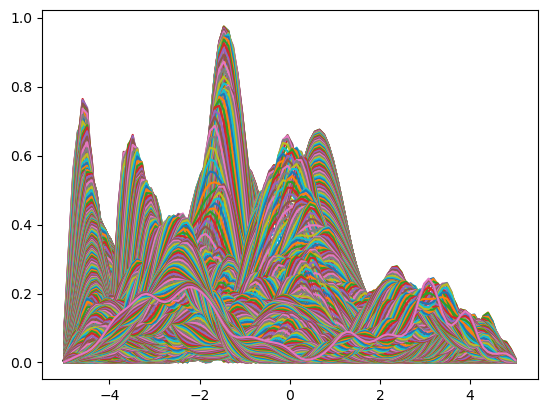

In [8]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,100)
minimo = np.zeros((1, 2000)).astype(complex)

while tempo < 1998:
    print(u1)
    psi_g[0:100, tempo] = psi[0:100, tempo]
    plt.plot(xs, np.absolute(psi[0:100, tempo])**2)
    u2 = optimize.minimize(Objetivo, u1, args=(tempo, psi_g, psiExato), method='CG')
    print(f"Iteração: {tempo+1}")
    print(u2)
    print("---------------")
    minimo[0][tempo] = (u2.x[0])
    D = multMatrizes(M = 100, us = u2.x[0])
    psi[0:100, tempo+1] = np.matmul(D, psi[0:100, tempo])
    tempo += 1
    u1 = []
    u1.append(u2.x[0])
    u1.append(random.uniform(-5, 5))
    u1.append(random.uniform(-5, 5))
    u1.append(random.uniform(-5, 5))

tempoFinal = time.time() - tempoInicial
print(tempoFinal)

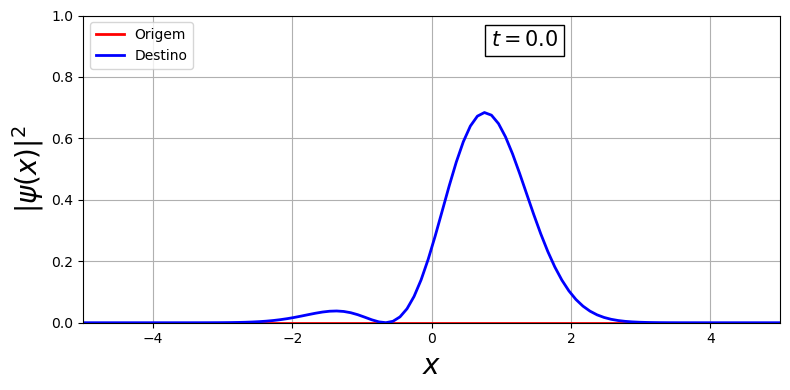

In [10]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,100)
    ln1.set_data(xs, np.absolute(psi_g[0:100,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:100,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Origem')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Destino')
time_text = ax.text(0.85, 0.9, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(0, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=2000, interval=2000)
ani.save('100x100.gif',writer='pillow',fps=20,dpi=100)